In [6]:
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# Data Quality Assesment

In [7]:
dataset = pd.read_json('./News_Category_Dataset_v2.json', lines=True)
dataset.drop(['authors', 'link', 'date'], axis = 1, inplace = True) 
dataset.head()

,category,headline,short_description
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",She left her husband. He killed their children. Just another day in America.
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment."""


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   short_description  200853 non-null  object
dtypes: object(3)
memory usage: 4.6+ MB


In [9]:
dataset.describe()

,category,headline,short_description
count,200853,200853,200853
unique,41,199344,178353
top,POLITICS,Sunday Roundup,
freq,32739,90,19712


In [10]:
print("We have a total of {} categories".format(dataset['category'].nunique()))
dataset['category'].value_counts()

We have a total of 41 categories


POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL            9887 
STYLE & BEAUTY    9649 
PARENTING         8677 
HEALTHY LIVING    6694 
QUEER VOICES      6314 
FOOD & DRINK      6226 
BUSINESS          5937 
COMEDY            5175 
SPORTS            4884 
BLACK VOICES      4528 
HOME & LIVING     4195 
PARENTS           3955 
THE WORLDPOST     3664 
WEDDINGS          3651 
WOMEN             3490 
IMPACT            3459 
DIVORCE           3426 
CRIME             3405 
MEDIA             2815 
WEIRD NEWS        2670 
GREEN             2622 
WORLDPOST         2579 
RELIGION          2556 
STYLE             2254 
SCIENCE           2178 
WORLD NEWS        2177 
TASTE             2096 
TECH              2082 
MONEY             1707 
ARTS              1509 
FIFTY             1401 
GOOD NEWS         1398 
ARTS & CULTURE    1339 
ENVIRONMENT       1323 
COLLEGE           1144 
LATINO VOICES     1129 
CULTURE & ARTS    1030 
EDUCATION         1004 
Name: category, 

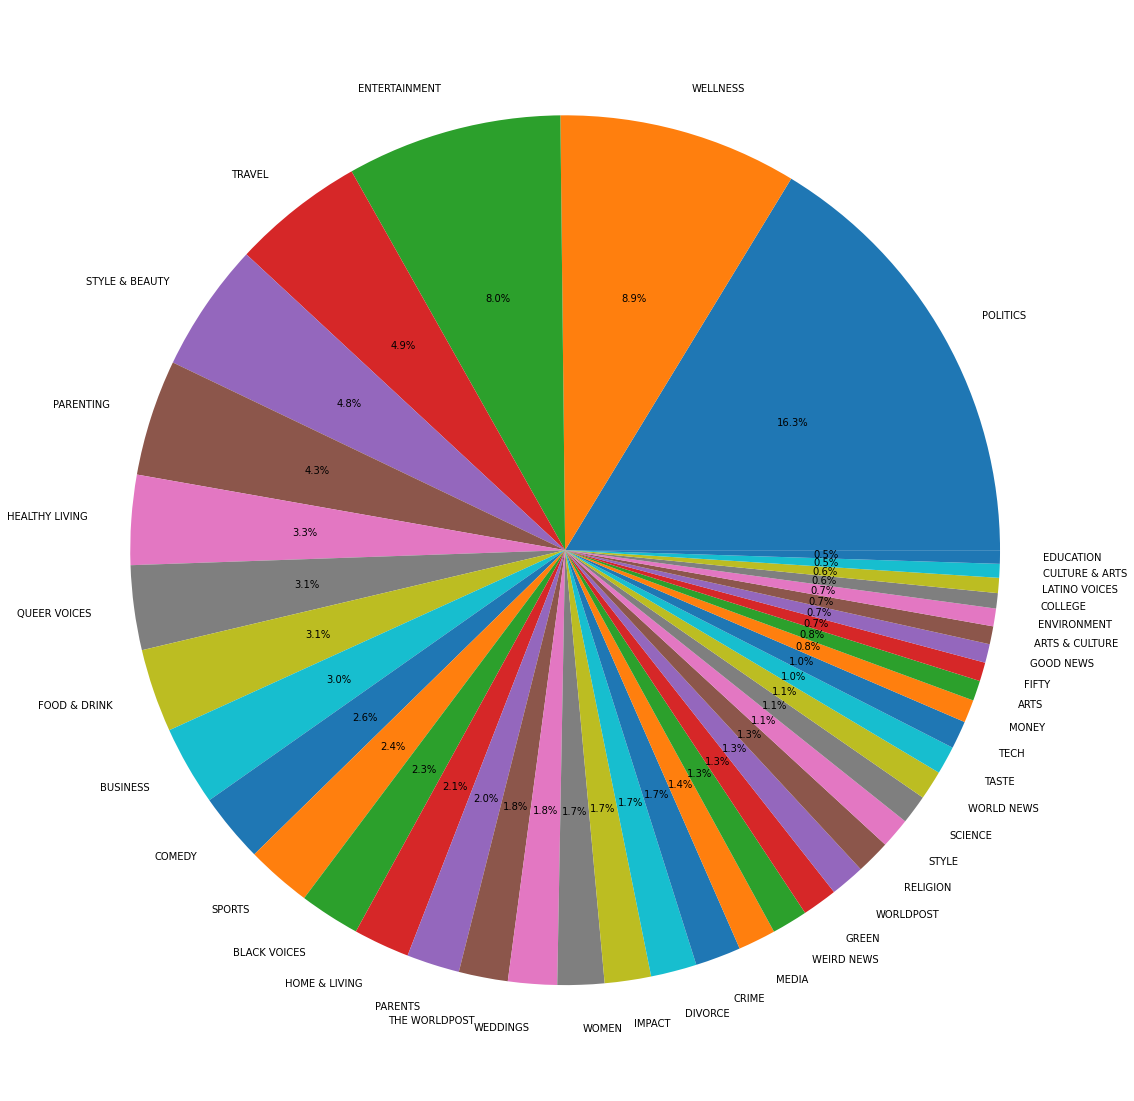

In [11]:
fig = plt.figure(figsize=(20,20))
plt.pie(dataset['category'].value_counts().values, 
        labels=dataset['category'].value_counts().index,
        autopct='%1.1f%%');

## Group the Categories

Let's try to group these categories and try to balance the dataset at the same time

In [12]:
categories = dataset['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            dataset.loc[dataset['category'] == ele, 'category'] = name

In [13]:
groupper( grouplist= ['POLITICS', 'BLACK VOICES'] , name =  'politics')

groupper( grouplist= [ 'WELLNESS', 'SPORTS', 'HEALTHY LIVING'] , name =  'sports')

groupper( grouplist= ['ENTERTAINMENT','TRAVEL' , 'STYLE & BEAUTY','WEIRD NEWS','ARTS', 'FOOD & DRINK', 'COMEDY', 'HOME & LIVING', 'STYLE', 'TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'entertainment')

groupper( grouplist= ['TECH'] , name =  'technology')

groupper( grouplist= ['SCIENCE'] , name =  'science')

In [14]:
print("We have a total of {} categories now".format(dataset['category'].nunique()))
dataset['category'].value_counts()

We have a total of 27 categories now


entertainment    62088
politics         37267
sports           29405
PARENTING        8677 
QUEER VOICES     6314 
BUSINESS         5937 
PARENTS          3955 
THE WORLDPOST    3664 
WEDDINGS         3651 
WOMEN            3490 
IMPACT           3459 
DIVORCE          3426 
CRIME            3405 
MEDIA            2815 
GREEN            2622 
WORLDPOST        2579 
RELIGION         2556 
science          2178 
WORLD NEWS       2177 
technology       2082 
MONEY            1707 
FIFTY            1401 
GOOD NEWS        1398 
ENVIRONMENT      1323 
COLLEGE          1144 
LATINO VOICES    1129 
EDUCATION        1004 
Name: category, dtype: int64

In [15]:
dataset = dataset[dataset['category'].isin(['politics', 'entertainment', 'science', 'technology', 'sports'])]

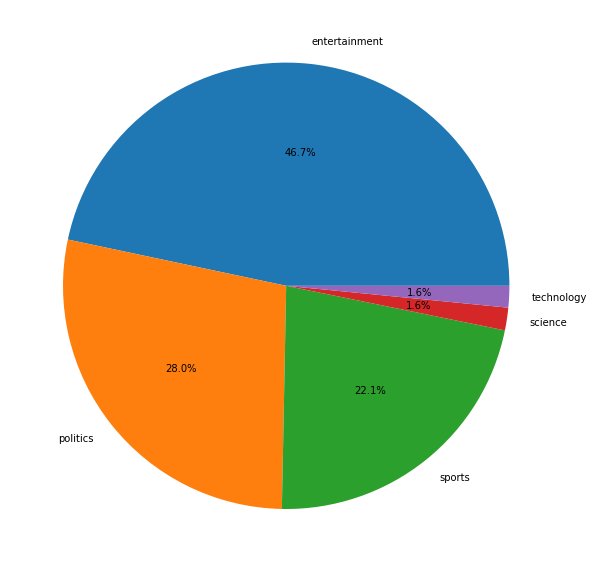

In [16]:
fig = plt.figure(figsize=(10,20))
plt.pie(dataset['category'].value_counts().values, 
        labels=dataset['category'].value_counts().index,
        autopct='%1.1f%%');

## Removing empty values and duplicates

### Duplicate Values

In [17]:
df = dataset.copy() #Let's create a copy of the data frame


In [18]:
df.duplicated().sum()  #total duplicates

274

In [19]:
df.drop_duplicates(keep='last', inplace=True) 

In [20]:
df.duplicated(subset=['short_description','headline']).sum() #duplicates under 'short_description' and 'headline'

3

In [21]:
df.drop_duplicates(subset=['short_description','headline'],keep='last',inplace=True)

### Empty Values

In [22]:
print(len(df[df['headline'] == ""]))

1


In [23]:
df.loc[df['headline'] == "", 'headline'] = np.nan
df.dropna(subset=['headline'], inplace=True)
print(len(df[df['headline'] == ""]))

0


In [24]:
print(len(df[df['short_description'] == ""]))


11850


In [25]:
df.loc[df['short_description'] == "", 'short_description'] = np.nan
df.dropna(subset=['short_description'], inplace=True)
print(len(df[df['short_description'] == ""]))

0


## Data Tidying

In [26]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 

In [27]:
df.head()

,category,headline,short_description
0,technology,Reducing U.S. Cyber Risk And The 45th President: A New Approach,"On December 1st, the President’s Commission on Enhancing National Cybersecurity (PCENC) released their final report. The"
1,entertainment,How To Transform This Forever 21 Colorblock Dress: From The Stylelist Network,"From Ramshackle Glam: Mix in a few extra color splashes and a touch of white, ground the whole look with a perfect denim"
2,politics,"Obama: Sorry, But We've Got To Give Trump Classified Briefings",He is still the Republican nominee.
3,entertainment,7 Easy Back-to-School Breakfasts,"We all want to start off on the right foot when starting a new school year. I know cereal and frozen waffles are often a necessity, but here are a few other easy options that will make parents and kids happy."
4,entertainment,"Jonathan Adler's Favorite Children's Book Is 'Miss Piggy's Guide To Life,' We're Not Surprised","If you were ever curious where designer Jonathan Adler got his child-like imagination, you can thank one Miss Piggy. Have"


In [28]:
df['desc'] = df['headline'].astype(str)+"-"+df['short_description']
df.drop(columns =['headline','short_description'],axis = 1, inplace=True)
df.astype(str)
df.head()

,category,desc
0,technology,"Reducing U.S. Cyber Risk And The 45th President: A New Approach-On December 1st, the President’s Commission on Enhancing National Cybersecurity (PCENC) released their final report. The"
1,entertainment,"How To Transform This Forever 21 Colorblock Dress: From The Stylelist Network-From Ramshackle Glam: Mix in a few extra color splashes and a touch of white, ground the whole look with a perfect denim"
2,politics,"Obama: Sorry, But We've Got To Give Trump Classified Briefings-He is still the Republican nominee."
3,entertainment,"7 Easy Back-to-School Breakfasts-We all want to start off on the right foot when starting a new school year. I know cereal and frozen waffles are often a necessity, but here are a few other easy options that will make parents and kids happy."
4,entertainment,"Jonathan Adler's Favorite Children's Book Is 'Miss Piggy's Guide To Life,' We're Not Surprised-If you were ever curious where designer Jonathan Adler got his child-like imagination, you can thank one Miss Piggy. Have"


# Tokenizing and Padding

In [29]:
X,Y = df['desc'],df['category']

#80% to train , 10% for validation , 10% for testing
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state=42)

In [30]:
vocab_size =20000
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [31]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_train = np.asarray(y_train)
y_train = pd.get_dummies(y_train)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1)   #this would be our ground truth label while testing

print(train_set.shape)
print(train_label.shape)


print(val_set.shape)
print(val_label.shape)




(96713, 150)
(96713, 5)
(12089, 150)
(12089, 5)


# Embedding Matrix for our model

In [32]:
!wget http://nlp.stanford.edu/data/glove.6B.zip #downloadingu glove vec word embeddings


--2021-11-16 15:31:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-16 15:31:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-16 15:31:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [33]:
!unzip -q glove.6B.zip #unzipping 

In [34]:
path_to_glove_file =  './glove.6B.100d.txt'

In [35]:
#Initialising the embedding matrix with glove vec embeddings

num_tokens = len(tokenizer.word_index.items()) + 2
embedding_dim = 100
hits = 0
misses = 0


embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 56038 words (27773 misses)


# Model Training

In [36]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=3, min_delta=0.0001)


tf.keras.backend.clear_session()
embed_size = 100
model = keras.models.Sequential([
                                 
        Embedding(num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        mask_zero=True,input_shape=[None],trainable=False),
        keras.layers.Bidirectional(keras.layers.LSTM(256, dropout = 0.4)),
        keras.layers.Dense(5, activation="softmax")
            
        ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         8381300   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              731136    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 9,115,001
Trainable params: 733,701
Non-trainable params: 8,381,300
_________________________________________________________________


In [37]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit( train_set,train_label,
                     batch_size = 32,
                     steps_per_epoch=len(X_train) // 32, 
                     validation_data = (val_set , val_label),
                     validation_steps = len(val_set)//32, epochs=20,
                     callbacks=  early_stop )

Epoch 1/20
3022/3022 [==============================] - 196s 60ms/step - loss: 0.4992 - accuracy: 0.8223 - val_loss: 0.4084 - val_accuracy: 0.8577
Epoch 2/20
3022/3022 [==============================] - 175s 58ms/step - loss: 0.4073 - accuracy: 0.8552 - val_loss: 0.3731 - val_accuracy: 0.8682
Epoch 3/20
3022/3022 [==============================] - 173s 57ms/step - loss: 0.3711 - accuracy: 0.8680 - val_loss: 0.3532 - val_accuracy: 0.8772
Epoch 4/20
3022/3022 [==============================] - 172s 57ms/step - loss: 0.3457 - accuracy: 0.8749 - val_loss: 0.3444 - val_accuracy: 0.8798
Epoch 5/20
3022/3022 [==============================] - 173s 57ms/step - loss: 0.3192 - accuracy: 0.8853 - val_loss: 0.3464 - val_accuracy: 0.8802
Epoch 6/20
3022/3022 [==============================] - 169s 56ms/step - loss: 0.2976 - accuracy: 0.8925 - val_loss: 0.3445 - val_accuracy: 0.8830
Epoch 7/20
3022/3022 [==============================] - 174s 57ms/step - loss: 0.2790 - accuracy: 0.8988 - val_loss: 0

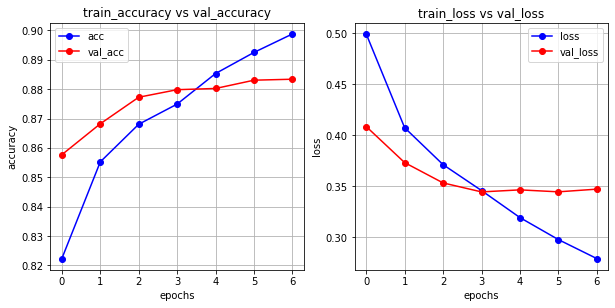

In [38]:
 fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()
